### Exploratory Data Analysis(EDA)

_Pavan Akula, September 15, 2018_

The goal of this assignment is build a data pipeline in Python that downloads _Titanic_ data from _Kaggle_ website, trains a classification model using sklearn and score the model on the test dataset.

Following steps are used to building the data pipeline. This notebook will focus mainly data imputation and model selection.

1. Install Python and required libraries using Anaconda framework
2. Download data from _Kaggle_ website
3. Run statistical summeries and impute missing values
4. Use visualzations to see spread of data in various categories
5. Build a predictive model using _sklearn_ library
6. Apply the model to test data to score it

#### Dataset

Dataset is downloaded from [Kaggle](https://www.kaggle.com/c/titanic/data), I will be using _train.csv_ to train the predictive model and _test.csv_ to score it. Since, _kaggle_ needs user name and password to download data, I have manually downloaded and uploaded to public repository on _Github_. For the scope of this analysis, I will be downloading the files from [Github](www.github.com/akulapa) and perform steps three through five.

In [1]:
#Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score

In [2]:
#Load dataset
train = pd.read_csv('https://raw.githubusercontent.com/akulapa/Data622-HW2/master/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/akulapa/Data622-HW2/master/test.csv')

In [3]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Training dataset has 

- PassengerId, it is running integer value to identify each passenger
- Survived, column contains binary value _0 or 1_, indicating if passenger survived in tragic Titanic accident
- Pclass, this is a categorical column with values _1, 2, and 3_, indicating passenger accomidation class
- Name, passenger name, it is combination of last name, prefix and first name
- Sex, gender of the passenger
- Age, age of the passenger, it is given as decimal
- SibSp, siblings and spouses traveling with the passenger
- Parch, number of parents and children traveling with the passenger
- Ticket, ticket numbers
- Cabin, cabin allocated to the passenger
- Embarked, port for which passenger boarded the ship, C = Cherbourg, Q = Queenstown, S = Southampton

In [5]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [6]:
test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [7]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Test dataset has same columns as training dataset, excepct it does not have _Survived_ column.

#### Variable Evaluation

Let see if all the variables has data and how it can be used to build the model. Idea is to convert all the variables into numeric equivalent where possible. Cases where variable is not possible to convert into numeric, we should be able to convert them into categorical values.

Starting with variable _Name_, it is in _lastname_, _prefix_ and _firstname_ format. It also has additional information next to _firstname_ within parentisis. Complete name may not be useful in model building. Hence, we will extract _prefix_ and store into new variable _Title_ that could be more useful in building predictive model.

Variable _Cabin_, upon investigation I found first letter in the values denote deck that was assigned to passenger. I believe deck would be more useful to predicting passenger survival.

Next in the variable sequence is _Ticket_, it is given as an alpha-numeric value. Intuitively, a numeric part of the value could be more useful in building a predictive model.

Variables _SibSp_ and _Parch_ could be used to derive total members in a passengers family. Ultimately, deriving the size of the family.

Finally, we have a dataset where every variable is either numeric or categorical. Now we can drop variables _Name_, _Cabin_, _Ticket_ and _Family_.


In [8]:
class derivedColumns(BaseEstimator, TransformerMixin):
    """
    This function creates derived columns using existing columns.
    """
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, *_):
        return self
    
    def transform(self, X, *_):
        
        df = X.copy()
        
        def cleanTicket(ticket):
            #Extract numeric values from ticket
            ticket = ticket.replace('.','')
            ticket = ticket.replace('/','')
            ticket = ticket.split()
            ticket = map(lambda t : t.strip(), ticket)
            ticket = filter(lambda t : t.isdigit(), ticket)
            ticket = ''.join(ticket)
            if len(ticket) > 0:
                return ticket
            else: 
                return np.nan
            
        #Based on column extract derived columns
        if self.columns is not None:
            for column in self.columns:
                
                if column == 'Name':
                    #Wikipedia suggests "Jonkheer" and "Countess" is honorific titile
                    #https://en.wikipedia.org/wiki/Jonkheer
                    #https://en.wikipedia.org/wiki/Count
                    #Create dictionary and map them more generic values

                    Title_Dictionary = {
                        "Capt": "Officer", "Col": "Officer", "Major": "Officer", "Jonkheer": "Royalty",
                        "Don": "Royalty", "Sir" : "Royalty", "Dr": "Officer", "Rev": "Officer",
                        "the Countess":"Royalty", "Mme": "Mrs", "Mlle": "Miss", "Ms": "Mrs",
                        "Mr" : "Mr", "Mrs" : "Mrs", "Miss" : "Miss", "Master" : "Master", "Lady" : "Royalty"
                    }

                    #Split name as comma seperated values and get second value(1) from the list
                    #Split the value again based on seperator(.), get first value(0)
                    #ultimately get prefix value
                    df['Title'] = df['Name'].map(lambda Name:Name.split(',')[1].split('.')[0].strip())
                    df['Title'] = df.Title.map(Title_Dictionary)

                if column == 'Ticket':
                    # map cleanTicket function and extract the value for each row:
                    df['TicketNumber'] = df['Ticket'].map(cleanTicket)

                if column == 'Family':
                    #Get number of members in the family
                    #Get family size
                    df['Family'] = (df['Parch'] + df['SibSp']).map(lambda s: 'Single' if s <= 1 else 'Small' if s >= 2 and s < 5 else 'Large' if s >= 5 else 'Unknown')
                    
                if column == 'Deck':
                    #Extract first letter from Cabin value, store it into new column 'Deck'
                    df['Deck'] = df.Cabin.str[0]
        return df
    
class eliminateColumns(BaseEstimator, TransformerMixin):
    """
    This function removed columns from dataset.
    """
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, *_):
        return self
    
    def transform(self, X, *_):
        
        df = X.copy()
        
        if self.columns is not None:
            #Drop the variables
            df.drop(self.columns, inplace=True, axis=1)
       
        return df

class imputeColumns(BaseEstimator, TransformerMixin):
    """
    This function fills in missing values in the dataset.
    """
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, *_):
        return self
    
    def transform(self, X, *_):
        
        #Copy train dataset, make transformations on df
        df = X.copy()
        
        def getTitle(gender):
            #Impute missing title based on gender
            title = ''
            if gender == 'female':
                title = 'Miss'
            else:
                title = 'Mr'
            return title
            
        
        if self.columns is not None:
            for column in self.columns:
                #Impute title, get null values and apply function getTitle using lambda
                if column == 'Title':
                    dfTitle = df[df['Title'].isnull()]
                    
                    title = dfTitle.apply(lambda row: getTitle(row['Sex']), axis=1)
                    df.loc[(df.Title.isnull()), 'Title'] = title
                    
                if column == 'Fare':
                    #Get median fare based on boarding port
                    fareMedian = df[((df['Fare'].notnull()) & (df['Embarked']=='S'))].Fare.median()
                    df['Fare'] = df['Fare'].fillna(float(fareMedian))
                
                if column == 'Deck':
                    #Since there more observations make missing Deck into its own category
                    df['Deck'] = df['Deck'].fillna('U')
                
                if column == 'TicketNumber':
                    #Get median value
                    #Replace missing ticketNumber by median values
                    ticketMedian = df[df['TicketNumber'].notnull()].TicketNumber.median()
                    df['TicketNumber'] = df['TicketNumber'].fillna(int(ticketMedian))
                    
                if column == 'Embarked':
                    #As fare matches the average fare impute missing value with 'C'
                    df['Embarked'] = df['Embarked'].fillna('C')
                if column == 'Age':

                    #Convet values into numeric categorical values
                    df['Sex'] = df['Sex'].map({'female':0, 'male':1})
                    df['Family'] = df['Family'].map({'Single':0, 'Small':1, 'Large':2})
                    df['Title'] = df['Title'].map({'Mrs':0, 'Miss':1, 'Mr':2, 'Master':3, 'Officer':4, 'Royalty':5})
                    df['Embarked'] = df['Embarked'].map({'C':0, 'Q':1, 'S':2})
                    df['Deck'] = df['Deck'].map({'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'T':7, 'U':8})

                    #Convert variables into categorical variables
                    df['Sex'] = df['Sex'].astype('category')
                    df['Family'] = df['Family'].astype('category')
                    df['Title'] = df['Title'].astype('category')
                    df['Embarked'] = df['Embarked'].astype('category')
                    df['Deck'] = df['Deck'].astype('category')
                    df['Pclass'] = df['Pclass'].astype('category')

                    #Get observations with non NA values for Age
                    train_age = df.loc[(df.Age.notnull())]

                    #Get observations with NA values for Age
                    test_age = df.loc[(df.Age.isnull())]

                    #Seperate X and y values for training dataset
                    X_age_train = train_age.drop('Age', axis=1).values
                    y_age_train = train_age['Age'].values

                    #As we will imputing missing Age values, drop the column from test dataset
                    X_age_test = test_age.drop('Age', axis=1).values

                    #Lets use all parameters as default, with number trees as 500 in random forest regressor
                    ramdomForest = RandomForestRegressor(n_estimators=500, n_jobs=-1)
                    ramdomForest.fit(X_age_train, y_age_train)

                    #Predict the missing values
                    predictedAges = ramdomForest.predict(X_age_test)

                    #Apply to the dataset
                    df.loc[(df.Age.isnull()), 'Age'] = predictedAges


        return df

In [9]:
#Split dataset into dependent and non-dependent dataset
X_train = train.drop('Survived', axis=1)
y_train = train['Survived']

In [10]:
#New variables are derived using following
derived_cols = ['Name', 'Ticket', 'Family', 'Deck']
dPipeLine = Pipeline([
    
    ('d_cols', derivedColumns( derived_cols ))
])

#Display output
pipelineOutput = dPipeLine.fit_transform(X_train)
print(pipelineOutput.shape)
pipelineOutput.head()

(891, 15)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TicketNumber,Family,Deck
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,21171,Single,NaN
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,17599,Single,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,3101282,Single,NaN
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,113803,Single,C
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,373450,Single,NaN


In [11]:
#Remove not used columns
elmi_cols = ['Name', 'Ticket', 'Cabin', 'PassengerId']
ePipeLine = Pipeline([
    
    ('d_cols', dPipeLine),
    ('e_cols', eliminateColumns( elmi_cols ))
])

#Display output
pipelineOutput = ePipeLine.fit_transform(X_train)
print(pipelineOutput.shape)
pipelineOutput.head()

(891, 11)


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,TicketNumber,Family,Deck
0,3,male,22.0,1,0,7.2500,S,Mr,21171,Single,NaN
1,1,female,38.0,1,0,71.2833,C,Mrs,17599,Single,C
2,3,female,26.0,0,0,7.9250,S,Miss,3101282,Single,NaN
3,1,female,35.0,1,0,53.1000,S,Mrs,113803,Single,C
4,3,male,35.0,0,0,8.0500,S,Mr,373450,Single,NaN


In [12]:
#Columns with null values
pipelineOutput.isnull().sum()

Pclass            0
Sex               0
Age             177
SibSp             0
Parch             0
Fare              0
Embarked          2
Title             0
TicketNumber      4
Family            0
Deck            687
dtype: int64

Text(0.5,1,'Variables with missing values')

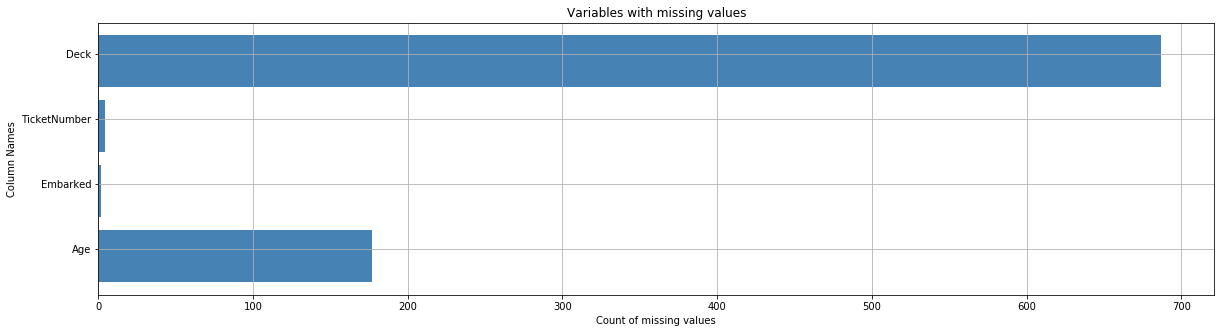

In [13]:
#Get null columns
null_columns=pipelineOutput.columns[pipelineOutput.isnull().any()]

#Graphical representation
labels = []
values = []
for col in null_columns:
    labels.append(col)
    values.append(pipelineOutput[col].isnull().sum())
ind = np.arange(len(labels))
width=0.6
fig, ax = plt.subplots(figsize=(20,5))
ax.grid()
rects = ax.barh(ind, np.array(values), color='steelblue')
ax.set_yticks(ind+((width)/5.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_ylabel("Column Names")
ax.set_title("Variables with missing values")

There are four variables, _Age_, _Embarked_, _Deck_ and _TicketNumber_ with missing values. 


Starting with _Embarked_ let's impute one variable at a time. Possible values for _Embarked_ are C = Cherbourg, Q = Queenstown, S = Southampton.

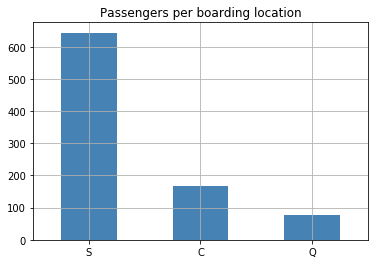

In [14]:
pipelineOutput.Embarked.value_counts().plot(kind='bar', color='steelblue', grid=True, rot=0)
plt.title("Passengers per boarding location");

In [15]:
#Get average price per port
pipelineOutput.groupby('Embarked').agg('mean')['Fare']

Embarked
C    59.954144
Q    13.276030
S    27.079812
Name: Fare, dtype: float64

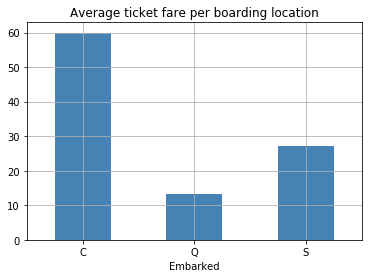

In [16]:
#Graphical presentation
pipelineOutput.groupby('Embarked').agg('mean')['Fare'].plot(kind='bar', color='steelblue', grid=True, rot=0);
plt.title("Average ticket fare per boarding location");

In [17]:
df = pipelineOutput.groupby(['Embarked', 'Sex']).size().sort_values(ascending=False).reset_index(name='count')
df

,Embarked,Sex,count
0,S,male,441
1,S,female,203
2,C,male,95
3,C,female,73
4,Q,male,41
5,Q,female,36


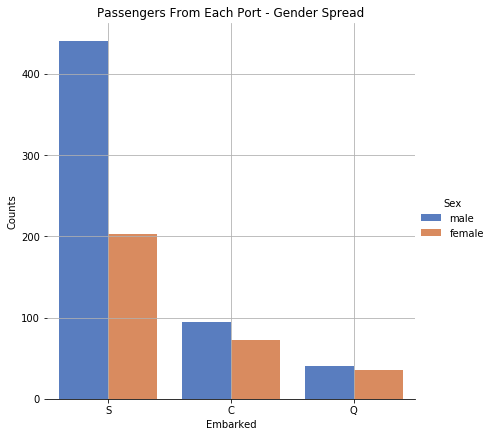

In [18]:
# Passengers From Each Port - Gender Spread
g = sns.catplot(x="Embarked", y="count", hue="Sex", data=df,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Counts")
plt.title("Passengers From Each Port - Gender Spread", fontsize=12);
plt.grid(True)

In [19]:
#Null value rows for Embarked column
pipelineOutput[pipelineOutput['Embarked'].isnull()]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,TicketNumber,Family,Deck
61,1,female,38.0,0,0,80.0,NaN,Miss,113572,Single,B
829,1,female,62.0,0,0,80.0,NaN,Mrs,113572,Single,B


Average _Fare_ matches _Fare_ paid by passengers boarding from port _Cherbourg_. Looking at average price and spread of gender boarding from _Cherbourg_ port we can manually update missing _Embarked_ value to C. 

In [20]:
#Null value rows for TicketNumber column
pipelineOutput[pipelineOutput['TicketNumber'].isnull()]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,TicketNumber,Family,Deck
179,3,male,36.0,0,0,0.0,S,Mr,NaN,Single,NaN
271,3,male,25.0,0,0,0.0,S,Mr,NaN,Single,NaN
302,3,male,19.0,0,0,0.0,S,Mr,NaN,Single,NaN
597,3,male,49.0,0,0,0.0,S,Mr,NaN,Single,NaN


Missing value for the _TicketNumber_ could be updated by median value because it almost random number given assigned to a passenger.

In [21]:
pipelineOutput['Fare'].groupby(pipelineOutput['Deck']).mean()

Deck
A     39.623887
B    113.505764
C    100.151341
D     57.244576
E     46.026694
F     18.696792
G     13.581250
T     35.500000
Name: Fare, dtype: float64

In [22]:
#Null value rows for Deck column
pipelineOutput[pipelineOutput['Deck'].isnull()].head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,TicketNumber,Family,Deck
0,3,male,22.0,1,0,7.2500,S,Mr,21171,Single,NaN
2,3,female,26.0,0,0,7.9250,S,Miss,3101282,Single,NaN
4,3,male,35.0,0,0,8.0500,S,Mr,373450,Single,NaN
5,3,male,NaN,0,0,8.4583,Q,Mr,330877,Single,NaN
7,3,male,2.0,3,1,21.0750,S,Master,349909,Small,NaN
8,3,female,27.0,0,2,11.1333,S,Mrs,347742,Small,NaN
9,2,female,14.0,1,0,30.0708,C,Mrs,237736,Single,NaN
12,3,male,20.0,0,0,8.0500,S,Mr,2151,Single,NaN
13,3,male,39.0,1,5,31.2750,S,Mr,347082,Large,NaN
14,3,female,14.0,0,0,7.8542,S,Miss,350406,Single,NaN


In [23]:
#Null value rows for Deck column
pipelineOutput[pipelineOutput['Deck']=='A'].head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,TicketNumber,Family,Deck
23,1,male,28.0,0,0,35.5000,S,Mr,113788,Single,A
96,1,male,71.0,0,0,34.6542,C,Mr,17754,Single,A
174,1,male,56.0,0,0,30.6958,C,Mr,17764,Single,A
185,1,male,NaN,0,0,50.0000,S,Mr,113767,Single,A
209,1,male,40.0,0,0,31.0000,C,Mr,112277,Single,A
284,1,male,NaN,0,0,26.0000,S,Mr,113056,Single,A
445,1,male,4.0,0,2,81.8583,S,Master,33638,Small,A
475,1,male,NaN,0,0,52.0000,S,Mr,110465,Single,A
556,1,female,48.0,1,0,39.6000,C,Royalty,11755,Single,A
583,1,male,36.0,0,0,40.1250,C,Mr,13049,Single,A


In [24]:
#Null value rows for Deck column
pipelineOutput[pipelineOutput['Deck']=='B'].head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,TicketNumber,Family,Deck
31,1,female,NaN,1,0,146.5208,C,Mrs,17569,Single,B
54,1,male,65.0,0,1,61.9792,C,Mr,113509,Single,B
61,1,female,38.0,0,0,80.0000,NaN,Miss,113572,Single,B
118,1,male,24.0,0,1,247.5208,C,Mr,17558,Single,B
139,1,male,24.0,0,0,79.2000,C,Mr,17593,Single,B
170,1,male,61.0,0,0,33.5000,S,Mr,111240,Single,B
194,1,female,44.0,0,0,27.7208,C,Mrs,17610,Single,B
195,1,female,58.0,0,0,146.5208,C,Miss,17569,Single,B
257,1,female,30.0,0,0,86.5000,S,Miss,110152,Single,B
263,1,male,40.0,0,0,0.0000,S,Mr,112059,Single,B


Since ticket _Fare_ increase or decrease is not consistent among the deck's and there are some cases in _Deck - B_, single passenger paid a very high price. It is safe to conclude that missing _Deck_ values can be classified into there own group. Let's replace missing _Deck_ with value 'U'.

Finally, variable _Age_ has 177 observations with missing values. I will using _RandomForestRegressor_ to find missing values. To run random forest regression on the data, we need to convert variables to numeric or categorical variables. 

Following _pipeline_ function imputes all missing values.

In [25]:
#Impute the columns and convert them into categorical values
imp_cols = ['Title', 'Fare', 'Deck', 'TicketNumber','Embarked','Age']
iPipeLine = Pipeline([
    
    ('e_cols', ePipeLine),
    ('i_cols', imputeColumns( imp_cols )),
])

#Display output
pipelineOutput = iPipeLine.fit_transform(X_train)
print(pipelineOutput.shape)
pipelineOutput.head()

(891, 11)


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,TicketNumber,Family,Deck
0,3,1,22.0,1,0,7.2500,2,2,21171,0,8
1,1,0,38.0,1,0,71.2833,0,0,17599,0,2
2,3,0,26.0,0,0,7.9250,2,1,3101282,0,8
3,1,0,35.0,1,0,53.1000,2,0,113803,0,2
4,3,1,35.0,0,0,8.0500,2,2,373450,0,8


In [26]:
print("Variables with missing values")
pipelineOutput.isnull().sum()

Variables with missing values


Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Embarked        0
Title           0
TicketNumber    0
Family          0
Deck            0
dtype: int64

#### Data Spread

None of the variables have missing values. This completes imputing missing values. Now let's see data distribution is normal or is it skewed. To find data spread we will be using boxplots and histograms. 

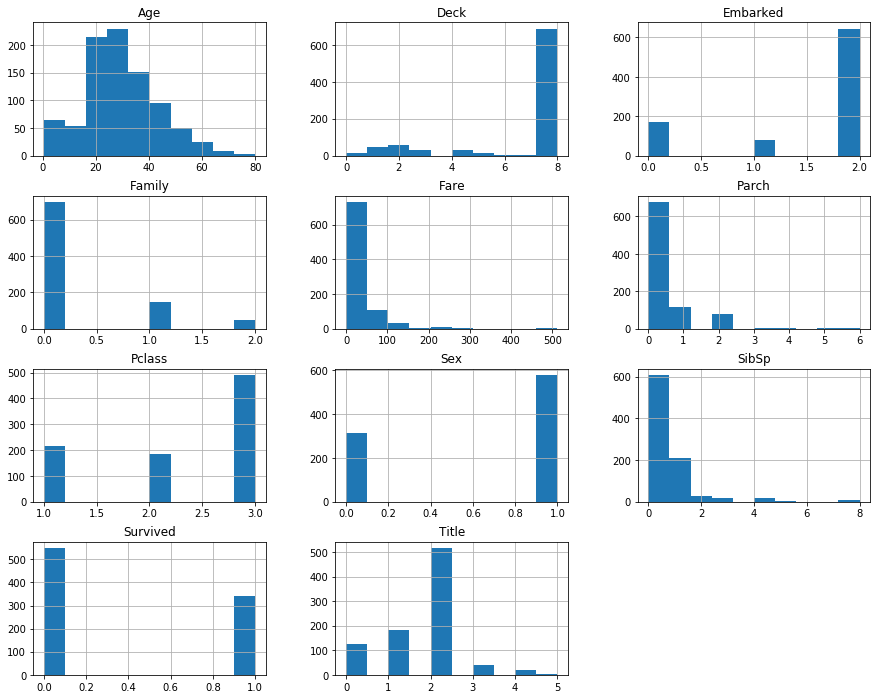

In [27]:
#Convert variables into into to check spread accross categories
#Histograms will give information about how data is spread

pipelineOutput['Sex'] = pipelineOutput['Sex'].astype('int')
pipelineOutput['Family'] = pipelineOutput['Family'].astype('int')
pipelineOutput['Title'] = pipelineOutput['Title'].astype('int')
pipelineOutput['Embarked'] = pipelineOutput['Embarked'].astype('int')
pipelineOutput['Deck'] = pipelineOutput['Deck'].astype('int')
pipelineOutput['Pclass'] = pipelineOutput['Pclass'].astype('int')

frames = [pipelineOutput, train['Survived']]
#Combine two datasets
df = pd.concat([pipelineOutput, train['Survived']], axis=1, join_axes=[pipelineOutput.index])


df['Survived'] = df['Survived'].astype('int')
#Check data spread
df.hist(bins=10,figsize=(15,12), grid=True);

#### Histogram Inference

- _Age_ the histogram shows data are normally distributed, with a single peak.
- _Deck_ is left-skewed, as there are more observations in category 8, this is imputed category.
- _Embarked_, the histogram shows that more passengers boarded from port Southampton, compared to other ports.
- _Family_, the histogram indicates that more passengers were traveling alone.
- _Fare_, the histogram shows that more than three fourth of the passengers paid fare less than \$100.00, few outliers paid fare higher than \$500.00. This makes the graph right-skewed.
- _Pclass_, histogram suggests more passengers were traveling in third class.
- _Sex_, graph suggests there were more male passengers on board.
- _Survived_, suggests that more female passengers survived the tragic Titanic accident.

Following graphs show how each variable is distributed against _Survived_ variable.

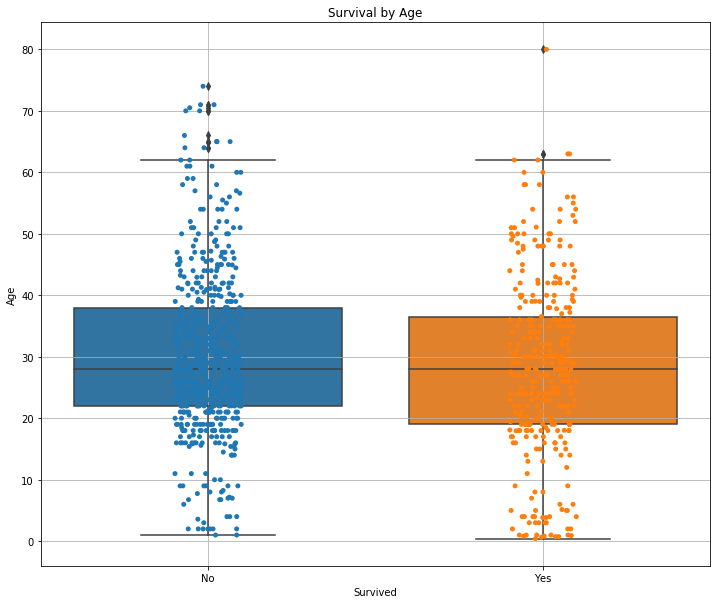

In [28]:
#Convert variables into categories
df['Sex'] = df['Sex'].astype('category')
df['Family'] = df['Family'].astype('category')
df['Title'] = df['Title'].astype('category')
df['Embarked'] = df['Embarked'].astype('category')
df['Deck'] = df['Deck'].astype('category')
df['Survived'] = df['Survived'].astype('category')
df['Pclass'] = df['Pclass'].astype('category')

df['Survived'] = df['Survived'].map({0:'No', 1:'Yes'})

#Spread between age and survival
fig, ax = plt.subplots(figsize=(12,10))
ax = sns.boxplot(x="Survived", y="Age", data=df)
ax = sns.stripplot(x="Survived", y="Age", data=df, jitter=True, edgecolor="gray")
ax.set_title("Survival by Age", fontsize=12);
plt.grid(True)

Median age of passenger that survived Vs. not is same, little less than 30 years. There are is an outlier in survial category where passenger age is approximately 80 years, yet surived. However, data spread accross age and survival is normally distributed.

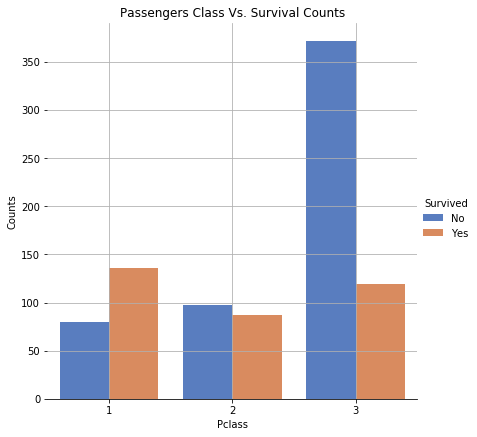

In [29]:
#Spread between passenger class and survival
df_ps = df.groupby(['Pclass', 'Survived']).size().sort_values(ascending=False).reset_index(name='count')

g = sns.catplot(x="Pclass", y="count", hue="Survived", data=df_ps,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Counts")
plt.title("Passengers Class Vs. Survival Counts", fontsize=12)
plt.grid(True)

In [30]:
df_ps.sort_values(['Pclass', 'Survived']) #Spread between passenger class and survival

,Pclass,Survived,count
5,1,No,80
1,1,Yes,136
3,2,No,97
4,2,Yes,87
0,3,No,372
2,3,Yes,119


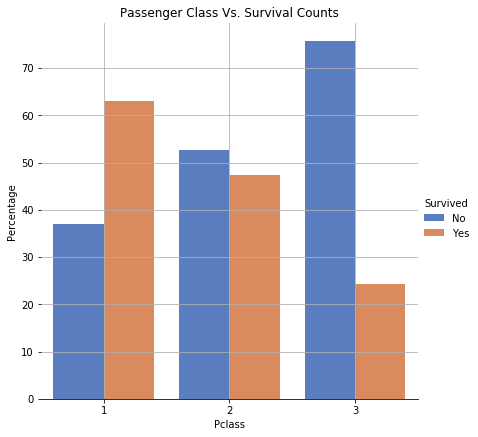

In [31]:
#Calculate percentages
df1 = df.groupby(['Pclass']).size().sort_values(ascending=False).reset_index(name='total')

result = pd.merge(df_ps, df1, on='Pclass', how='inner')
result['Percentage'] = (result['count']*100)/result['total']

g = sns.catplot(x="Pclass", y="Percentage", hue="Survived", data=result,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Percentage")
plt.title("Passenger Class Vs. Survival Counts", fontsize=12)
plt.grid(True)

Data suggests, there is a slightly higher chance of survival if the passenger is from first class, survival chance is almost the same for passengers with a second-class ticket. However, for a passenger with a third-class ticket survival chance is very low. 

It is safe to assume that ticket class profoundly influences passenger survival chances.

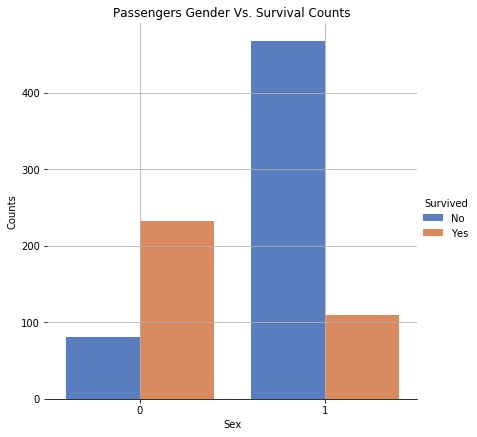

In [32]:
#Spread between gender and survival
df1 = df.groupby(['Sex', 'Survived']).size().sort_values(ascending=False).reset_index(name='count')

g = sns.catplot(x="Sex", y="count", hue="Survived", data=df1,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Counts")
plt.title("Passengers Gender Vs. Survival Counts", fontsize=12);
plt.grid(True)

In [33]:
df1.sort_values(['Sex', 'Survived']) #Spread between gender and survival

,Sex,Survived,count
3,0,No,81
1,0,Yes,233
0,1,No,468
2,1,Yes,109


Data suggests, female passengers have higher chance of survival compared to male passengers.

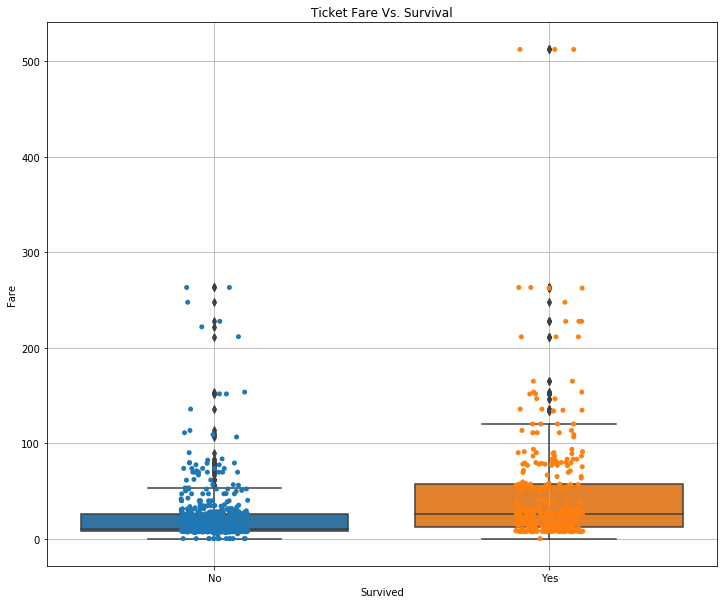

In [34]:
#Spread between ticket fare and survival
fig, ax = plt.subplots(figsize=(12,10))
ax = sns.boxplot(x="Survived", y="Fare", data=df)
ax = sns.stripplot(x="Survived", y="Fare", data=df, jitter=True, edgecolor="gray")
ax.set_title("Ticket Fare Vs. Survival", fontsize=12);
plt.grid(True)

In [35]:
#Passengers paying fare greater than dollars 500
df[df['Fare']>=500].head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,TicketNumber,Family,Deck,Survived
258,1,0,35.0,0,0,512.3292,0,1,17755,0,8,Yes
679,1,1,36.0,0,1,512.3292,0,2,17755,0,1,Yes
737,1,1,35.0,0,0,512.3292,0,2,17755,0,1,Yes


Data suggests that there are few outliers in survival class that has paid above \$500 per ticket. However, it would be incorrect assumption that paying higher fare saves lives. It could be a coincidence that passengers booked a first class ticket at the last minute. Overall, data distribution looks normal.

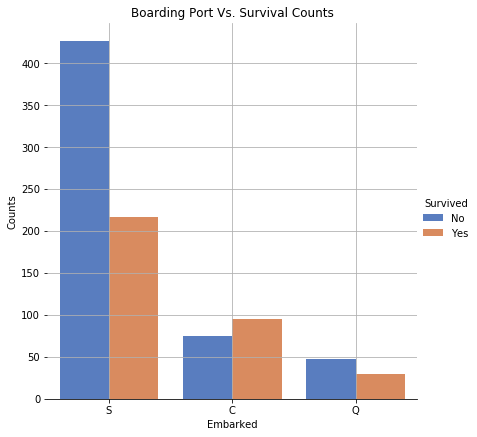

In [36]:
#Spread between embarked and survival
df_e = df.groupby(['Embarked', 'Survived']).size().sort_values(ascending=False).reset_index(name='count')
df_e['Embarked'] = df_e['Embarked'].map({0:'C', 1:'Q', 2:'S'})

g = sns.catplot(x="Embarked", y="count", hue="Survived", data=df_e,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Counts")
plt.title("Boarding Port Vs. Survival Counts", fontsize=12)
plt.grid(True)

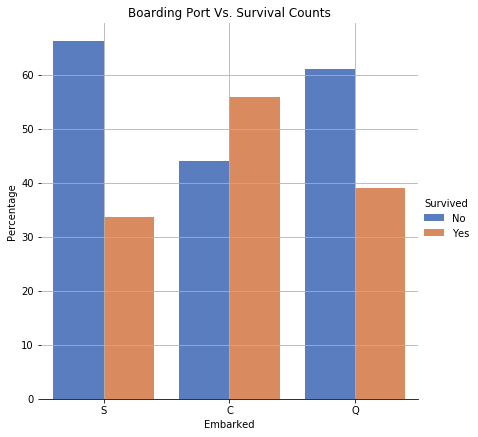

In [37]:
#Calculate percentages
df_ep = df.groupby(['Embarked']).size().sort_values(ascending=False).reset_index(name='total')
df_ep['Embarked'] = df_ep['Embarked'].map({0:'C', 1:'Q', 2:'S'})

result = pd.merge(df_e, df_ep, on='Embarked', how='inner')
result['Percentage'] = (result['count']*100)/result['total']

g = sns.catplot(x="Embarked", y="Percentage", hue="Survived", data=result,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Percentage")
plt.title("Boarding Port Vs. Survival Counts", fontsize=12)
plt.grid(True)

Data suggests, passengers boarding from Southampton port has low survival chance compared to a passenger from other ports. However, it is also true that a high number of passengers boarded from Southhampton port.

When counts are converted into percentages, survival chance is approximately the same for both the Southhampton and Queenstown ports. It is low compared to Cherbourg. On the other hand, the chance of survival vs.not is almost the same for passengers boarding from Cherbourg port.

It is safe to assume that boarding port has no substantial influence on passenger survival.

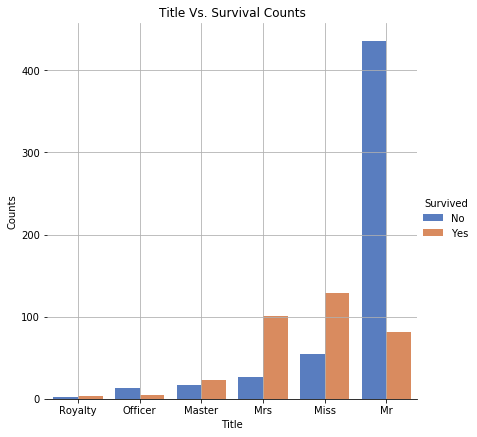

In [38]:
#Spread between title and survival
df_t = df.groupby(['Title', 'Survived']).size().sort_values(ascending=True).reset_index(name='count')
df_t['Title'] = df_t['Title'].map({0:'Mrs', 1:'Miss', 2:'Mr', 3:'Master', 4:'Officer', 5:'Royalty'})

g = sns.catplot(x="Title", y="count", hue="Survived", data=df_t,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Counts")
plt.title("Title Vs. Survival Counts", fontsize=12)
plt.grid(True)

Data suggests that female passengers has higher chance of survival.

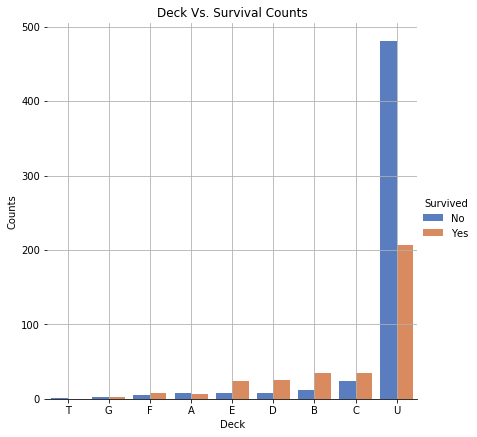

In [39]:
#Spread between Deck and survival
df_d = df.groupby(['Deck', 'Survived']).size().sort_values(ascending=True).reset_index(name='count')
df_d['Deck'] = df_d['Deck'].map({0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'T', 8:'U'})

g = sns.catplot(x="Deck", y="count", hue="Survived", data=df_d,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Counts")
plt.title("Deck Vs. Survival Counts", fontsize=12)
plt.grid(True)

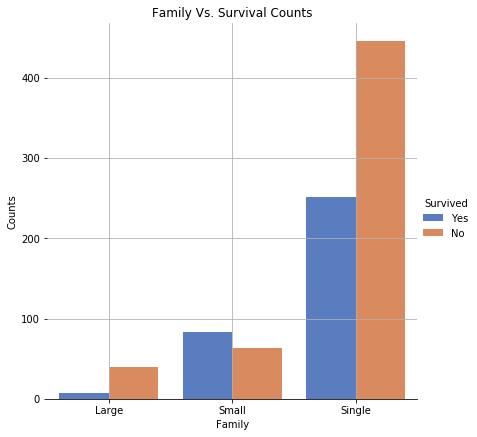

In [40]:
#Spread between Family and survival
df_f = df.groupby(['Family', 'Survived']).size().sort_values(ascending=True).reset_index(name='count')
df_f['Family'] = df_f['Family'].map({0:'Single', 1:'Small', 2:'Large'})

g = sns.catplot(x="Family", y="count", hue="Survived", data=df_f,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Counts")
plt.title("Family Vs. Survival Counts", fontsize=12)
plt.grid(True)

_Deck_ and _Family_ are derived variables. No clear inference can be drawn from these variables other than there were more single passengers on board.

#### Variable Importance To The Model

Using _LogisticRegression_ module let's see importance of variable to the model.

In [41]:
# Create independent variable list
X = pipelineOutput

# Create dependent variable
y = y_train

logreg = LogisticRegression()

rfe = RFE(logreg, 20)
rfe = rfe.fit(X, y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1]


Recursive Feature Elimination(_RFE_) suggests that all variables are contributing to the model in predicting dependent variable _Survived_.

Using _RandomForestRegressor_ module let's see importance of variable to the model.

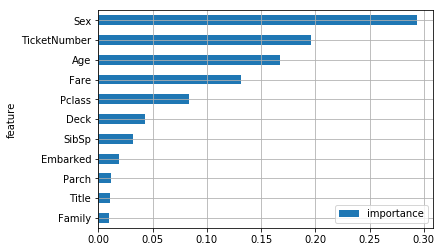

In [42]:
# Initiate the model
model = RandomForestRegressor(n_estimators=100, random_state=1, oob_score=True)
model.fit(X, y)

#Get ROC values
roc_auc_score(y, model.oob_prediction_)

#Extract variable importance
features = pd.DataFrame()
features['feature'] = X.columns
features['importance'] = model.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh', grid=True)


#### Model

Since the dependent variable is binary, it is appropriate to use _Logistic Regression_. I will be using two different methods to build the model using the _sklearn_ library.

#### Logistic Regression

In [43]:
#Building logistic regression
pipeline = Pipeline([
    ('final_dataset', iPipeLine),
    ('clf', LogisticRegression())
])

scores = cross_validate(pipeline, X_train, y_train)
scores

/home/data622/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([1.36492848, 0.94808793, 0.97768593]),
 'score_time': array([0.67824411, 0.6361258 , 0.7568326 ]),
 'test_score': array([0.62289562, 0.68013468, 0.61616162]),
 'train_score': array([0.67845118, 0.65993266, 0.61616162])}

In [44]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(scores['test_score'].mean()))

Accuracy of logistic regression classifier on test set: 0.64


In [45]:
clfs = []
clfs.append(LogisticRegression())
clfs.append(RandomForestRegressor())

for classifier in clfs:
    pipeline.set_params(clf = classifier)
    scores = cross_validate(pipeline, X_train, y_train)
    print('---------------------------------')
    print(str(classifier))
    print('-----------------------------------')
    for key, values in scores.items():
            print(key,' mean ', values.mean())
            print(key,' std ', values.std())

---------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
-----------------------------------
fit_time  mean  1.0082227389017742
fit_time  std  0.12431664872946221
score_time  mean  0.7112294832865397
score_time  std  0.053306462833147564
test_score  mean  0.6408529741863075
test_score  std  0.03028223919917405
train_score  mean  0.6487093153759821
train_score  std  0.024945129933662057
---------------------------------
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, 

The Classifier _Logistic Regression_ has the highest accuracy of 64%, hence choosing _Logistic Regression_.

In [46]:
#Pass variables using GridSearchCV
pipeline.set_params(clf= LogisticRegression())
pipeline.steps

reg_param_grid = dict(
                  clf__penalty=['l1', 'l2'],
                  clf__C=[0.001, 0.01, 0.1, 1, 10],
                  clf__random_state=[1]
)

cv_grid = GridSearchCV(pipeline, param_grid = reg_param_grid)

cv_grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('final_dataset', Pipeline(memory=None,
     steps=[('e_cols', Pipeline(memory=None,
     steps=[('d_cols', Pipeline(memory=None,
     steps=[('d_cols', derivedColumns(columns=['Name', 'Ticket', 'Family', 'Deck']))])), ('e_cols', eliminateColumns(columns=['Name', 'Ticket', 'Cabin', 'Passenger...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__penalty': ['l1', 'l2'], 'clf__C': [0.001, 0.01, 0.1, 1, 10], 'clf__random_state': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [47]:
#As we are using various penalty or C values
cv_grid.best_params_

{'clf__C': 10, 'clf__penalty': 'l1', 'clf__random_state': 1}

In [48]:
#
cv_grid.best_estimator_

Pipeline(memory=None,
     steps=[('final_dataset', Pipeline(memory=None,
     steps=[('e_cols', Pipeline(memory=None,
     steps=[('d_cols', Pipeline(memory=None,
     steps=[('d_cols', derivedColumns(columns=['Name', 'Ticket', 'Family', 'Deck']))])), ('e_cols', eliminateColumns(columns=['Name', 'Ticket', 'Cabin', 'Passenger...nalty='l1', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [49]:
cv_grid.best_score_

0.7946127946127947

In [50]:
y_pred = cv_grid.predict(X_train)
accuracy = accuracy_score(y_train,y_pred)
print('Accuracy of the best classifier after CV is %.3f%%' % (accuracy*100))

Accuracy of the best classifier after CV is 80.471%


[[478  71]
 [103 239]]


Text(0.5,1,'Confusion Matrix - Survived')

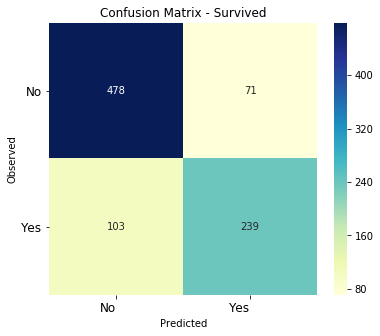

In [51]:
from sklearn.metrics import confusion_matrix as cm
labels = ['Observed', 'Predicted']
cm = cm(y_train, y_pred)
print(cm)

#Graphical display of confusion matrix
fig, ax = plt.subplots(figsize=(6,5))
fontsize=12
heatmap = sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", yticklabels=['No', 'Yes'], xticklabels=['No', 'Yes'])
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
plt.ylabel('Observed')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Survived')

Using _Logistic Regression_ module from _sklearn_ library, model predicts 

- 478 passengers did not survive, true positive.
- 103 passengers did not survive, in reality they survived, false positive
- 71 passengers as survived, in reality they did not survive, false negative
- 239 passengers as survived, true negative

In [52]:
#Show precision and f1-score
print(classification_report(y_train, y_pred))

             precision    recall  f1-score   support

          0       0.82      0.87      0.85       549
          1       0.77      0.70      0.73       342

avg / total       0.80      0.80      0.80       891



Precision, is the ratio of correctly predicted positive observations to the total predicted positive observations. In our case,

Not Survived(0) = $\frac{TP}{TP+FP} = \frac{478}{478+103} = 0.82$

Survived(1) = $\frac{TN}{TN+FN} = \frac{239}{73+239} = 0.77$

Recall, also known as sensitivity is the ratio of correctly predicted positive observations to the all observations in actual class - yes

Not Survived(0) = $\frac{TP}{TP+FN} = \frac{476}{476+73} = 0.87$

Survived(1) = $\frac{TN}{TN+FP} = \frac{239}{239+103} = 0.70$

F1 Score is the weighted average of Precision and Recall, in other words it _Harmonic mean_ of Precision and Recall

Not Survived(0) = $\frac{2*0.82*0.87}{0.82 + 0.87} = 0.84$

Survived(1) = $\frac{2*0.77*0.70}{0.77 + 0.70} = 0.73$

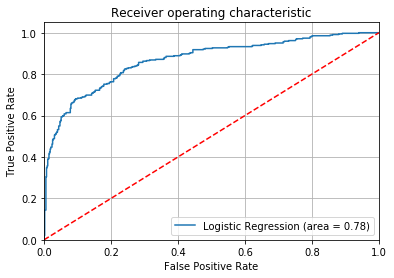

In [53]:
#Draw ROC Curve
logit_roc_auc = roc_auc_score(y_train, y_pred)
fpr, tpr, thresholds = roc_curve(y_train, cv_grid.predict_proba(X_train)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In case of ROC, higher value of area under the curve(AUC) means better model. In our case it 0.78.

#### References
- https://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html
- https://www.datacamp.com/community/tutorials/categorical-data
- https://www.youtube.com/watch?v=0GrciaGYzV0
- https://www.youtube.com/watch?v=URdnFlZnlaE
- https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
- https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/
- https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6
- https://towardsdatascience.com/the-tale-of-missing-values-in-python-c96beb0e8a9d
- https://www.kaggle.com/poonaml/titanic-survival-prediction-end-to-end-ml-pipeline/notebook
- http://www.colaberry.com/data-science-predictive-analytics-pipeline/
- http://blog.madhukaraphatak.com/analysing-kaggle-titanic-data/
- http://www.ultravioletanalytics.com/blog/kaggle-titanic-competition-part-iv-derived-variables
- https://github.com/philipmgoddard/pipelines/blob/master/pipe_demo.ipynb
- https://www.kaggle.com/gautham11/building-a-scikit-learn-classification-pipeline